# CNN models on distributions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src/")
from collections import OrderedDict
import cellbell

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils

from models import conv1D_distribution, conv2D_distribution
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
from sklearn.model_selection import train_test_split

Using Theano backend.
Using gpu device 0: GeForce GT 630M (CNMeM is disabled, cuDNN not available)


In [3]:
data_file = "../data/processed/ensemble-data.h5"
identifiers = pd.read_hdf(data_file, "predictions/identifiers")
one_week = pd.read_hdf(data_file, "predictions/one_week")
actual = pd.read_hdf(data_file, "actual")

## Mix models for predicting week 1

In [4]:
# Get common identifiers
df = pd.concat([identifiers, one_week], axis=1)

df["key"] = df["time"].map(str) + df["region"]
models = ["kde", "kcde", "sarima"]

intersection = np.intersect1d(df[df["model"] == models[0]]["key"],
                              df[df["model"] == models[1]]["key"])
intersection = np.intersect1d(intersection, df[df["model"] == models[2]]["key"])

df = df[df["key"].isin(intersection)]
df = df.drop("key", axis=1)

# Shift actual to handle one week ahead prediction
actual["time"] = actual["time"] - 1
df = pd.merge(actual, df, how="inner", on=["region", "time"])

df = df.sort_values(["model", "region", "time"])

In [5]:
kcde = df[df["model"] == "kcde"]
kde = df[df["model"] == "kde"]
sarima = df[df["model"] == "sarima"]

assert kcde.shape == kde.shape == sarima.shape

### Convert y to categories

In [6]:
n_bins = 131 # from 0 to 13 in steps of 0.1
bins = np.linspace(0, 13, num=n_bins)
Y = np.zeros((len(kcde), n_bins))

for i, elem in enumerate(kcde["actual"]):
    index = np.sum(elem > bins) - 1
    Y[i, index] = 1

In [7]:
X = np.exp(np.stack([kcde.iloc[:, 4:], kde.iloc[:, 4:], sarima.iloc[:, 4:]], axis=-1))

In [8]:
X_week = kcde["time"].as_matrix() % 100

### Training

In [135]:
X_train, X_test, X_week_train, X_week_test, Y_train, Y_test = train_test_split(X, X_week, Y,
                                                                               test_size=0.2, random_state=1234)

In [136]:
# Load pretrained embeddings
emb = np.load("../data/processed/week_embeddings.npy")

In [137]:
model = conv1D_distribution(3, n_bins, 20)
modelEmb = conv1D_distribution(3, n_bins, 20, week_embedding_matrix=emb)

In [138]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_45 (Convolution1D) (None, 131, 64)       1024        convolution1d_input_23[0][0]     
____________________________________________________________________________________________________
convolution1d_46 (Convolution1D) (None, 131, 20)       6420        convolution1d_45[0][0]           
____________________________________________________________________________________________________
flatten_59 (Flatten)             (None, 2620)          0           convolution1d_46[0][0]           
____________________________________________________________________________________________________
dense_115 (Dense)                (None, 30)            78630       flatten_59[0][0]                 
___________________________________________________________________________________________

In [139]:
modelEmb.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_47 (Convolution1D) (None, 131, 64)       1024        convolution1d_input_24[0][0]     
____________________________________________________________________________________________________
convolution1d_48 (Convolution1D) (None, 131, 20)       6420        convolution1d_47[0][0]           
____________________________________________________________________________________________________
flatten_61 (Flatten)             (None, 2620)          0           convolution1d_48[0][0]           
____________________________________________________________________________________________________
dense_119 (Dense)                (None, 30)            78630       flatten_61[0][0]                 
___________________________________________________________________________________________

In [140]:
model.compile(optimizer="adam", loss="categorical_crossentropy")
modelEmb.compile(optimizer="adam", loss="categorical_crossentropy")

In [141]:
%%ding
history = model.fit([X_train, X_week_train], Y_train,
                    batch_size=64, nb_epoch=25,
                    verbose=0, callbacks=[TQDMNotebookCallback()],
                    validation_split=0.2)

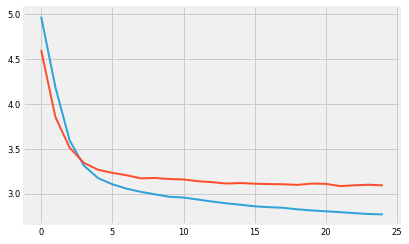

In [142]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [143]:
%%ding
history = modelEmb.fit([X_train, X_week_train], Y_train,
                       batch_size=64, nb_epoch=25,
                       verbose=0, callbacks=[TQDMNotebookCallback()],
                       validation_split=0.2)

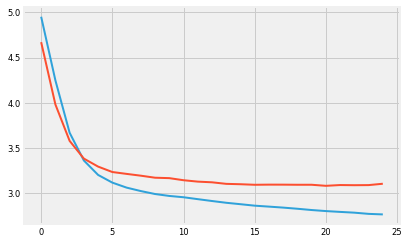

In [144]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [145]:
out = model.predict([X_test, X_week_test])
outEmb = modelEmb.predict([X_test, X_week_test])

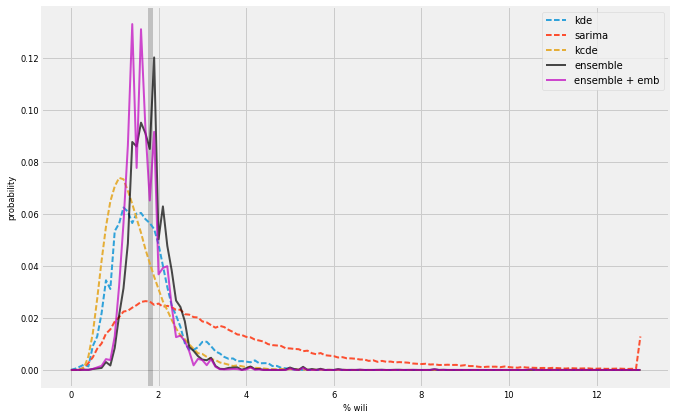

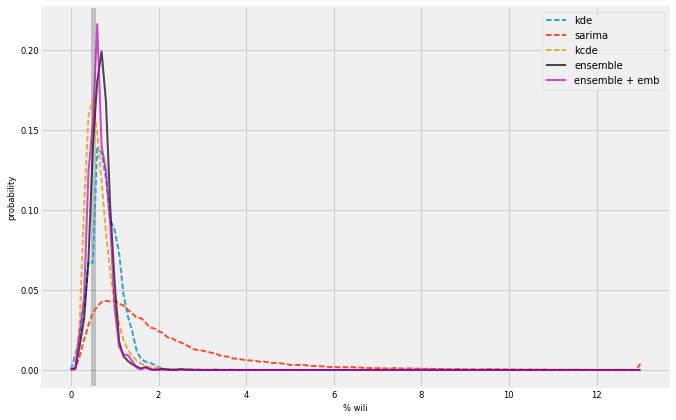

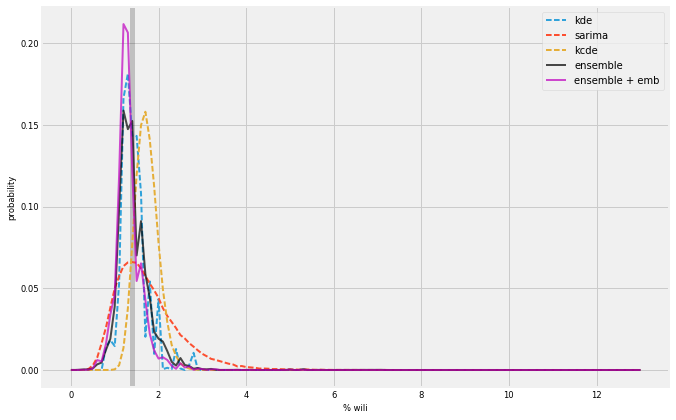

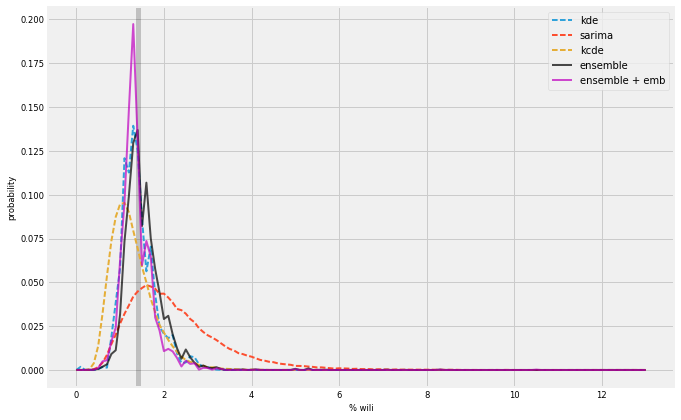

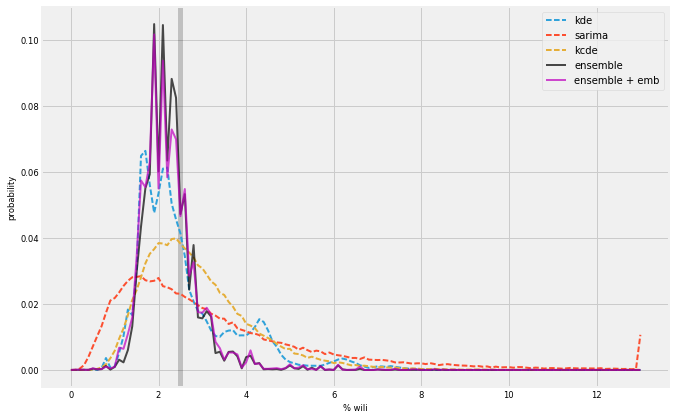

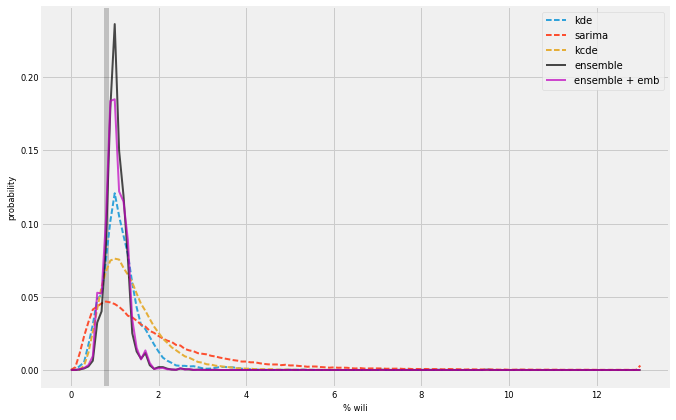

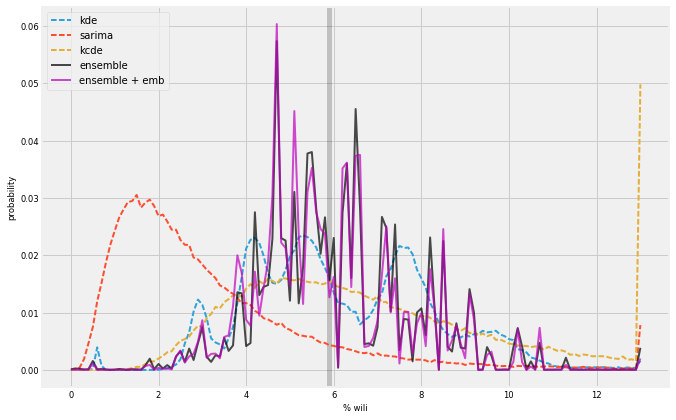

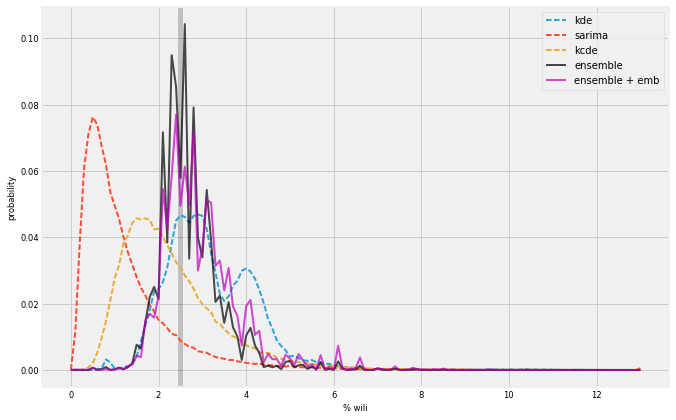

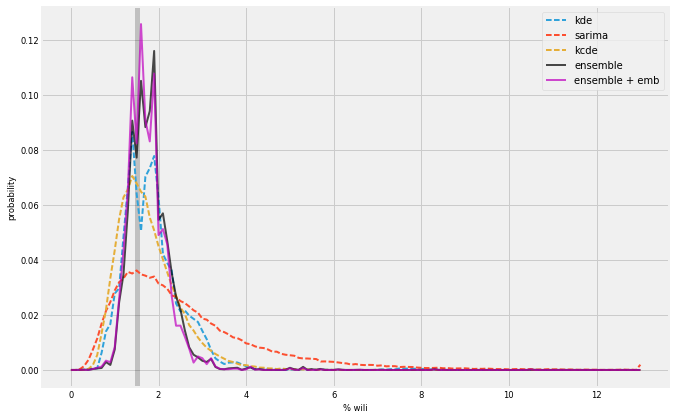

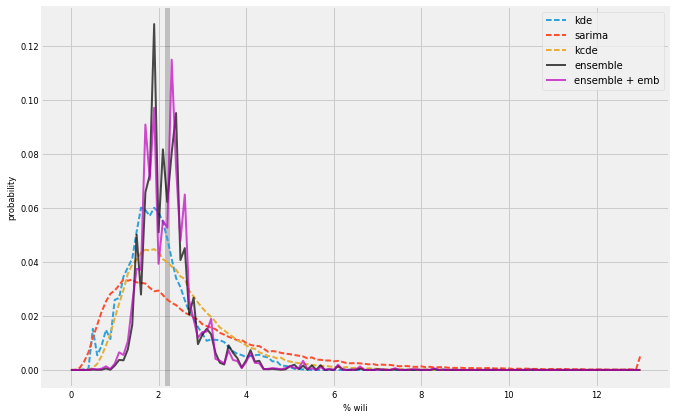

In [149]:
for i in range(10):
    index = np.random.randint(0, len(out))
    plt.figure(figsize=(10, 7))
    plt.axvline(x=bins[np.where(Y_test[index] == 1)[0][0]], linewidth=5, color="k", alpha=0.2)
    plt.plot(bins, X_test[index][:, 0], linestyle="--", label="kde")
    plt.plot(bins, X_test[index][:, 1], linestyle="--", label="sarima")
    plt.plot(bins, X_test[index][:, 2], linestyle="--", label="kcde")
    plt.plot(bins, out[index], color="k", alpha=0.7, label="ensemble")
    plt.plot(bins, outEmb[index], color="m", alpha=0.7, label="ensemble + emb")
    plt.xlabel("% wili")
    plt.ylabel("probability")
    plt.legend()

In [150]:
# print losses
print("Crossentropy loss\n")
print("kde:", utils.crossentropy_loss(Y_test, X_test[:, :, 0]).mean())
print("sarima:", utils.crossentropy_loss(Y_test, X_test[:, :, 1]).mean())
print("kcde:", utils.crossentropy_loss(Y_test, X_test[:, :, 2]).mean())
print("ensemble (conv1d):", utils.crossentropy_loss(Y_test, out).mean())
print("ensemble (conv1d+emb):", utils.crossentropy_loss(Y_test, outEmb).mean())

Crossentropy loss

kde: 2.91630887185
sarima: 3.6096329858
kcde: 3.05483678961
ensemble (conv1d): 2.84969071328
ensemble (conv1d+emb): 2.8272272143
